In [1]:
import pandas as pd
%matplotlib inline
import seaborn as sns
import scipy.stats as ss
import numpy as np

### *Creo un dataframe de pandas con los datos del taxonomy. Renombro la columna id a segment_id para luego poder hacer join con sample_df*

In [2]:
taxonomy_df = pd.read_csv('./taxonomy.csv')
taxonomy_df = taxonomy_df.rename(columns={'id':'segment_id'})
taxonomy_df = taxonomy_df.set_index(taxonomy_df.segment_id)
taxonomy_df = taxonomy_df.drop(columns=['segment_id'])

In [3]:
taxonomy_df.head()

,segment_type,cluster_name,segment_name,category
segment_id,,,,
2,General,Genero,Hombres,2
3,General,Genero,Mujeres,2
4,General,Rango de Edad,18-24,2
5,General,Rango de Edad,25-34,2
6,General,Rango de Edad,35-44,2


In [4]:
taxonomy_df['category'].unique()

array([2, 0, 1])

### *Creo un dataframe con los datos de las asignaciones*

In [5]:
sample_df = pd.read_csv('./sample_interviews.csv')

### *Renombro la columna segment a segment_id para luego poder hacer join con taxonomy*

In [6]:
sample_df = sample_df.rename(columns={'segment':'segment_id'})

### *Hago join entre las asinaciones y taxonomy para poder crear un dataframe que tega toda la informacion*

In [7]:
sample_ext_df = sample_df.join(taxonomy_df, on=['segment_id'])

### *Saco todos registros que no tienen informacion de segmento*

In [8]:
sample_ext_df = sample_ext_df[~sample_ext_df.category.isnull()]

In [9]:
sample_ext_df.head()

,segment_id,device_id,count,day,segment_type,cluster_name,segment_name,category
0,2,7342,67,10,General,Genero,Hombres,2.0
1,2,20388,5,17,General,Genero,Hombres,2.0
2,2,25478,5,4,General,Genero,Hombres,2.0
3,2,27387,41,1,General,Genero,Hombres,2.0
4,2,28601,31,1,General,Genero,Hombres,2.0


In [10]:
sample_df.head()

,segment_id,device_id,count,day
0,2,7342,67,10
1,2,20388,5,17
2,2,25478,5,4
3,2,27387,41,1
4,2,28601,31,1


In [11]:
asignados_por_segmento = sample_ext_df.groupby('segment_id').count()['count']

### *Cual es el segmento con mayor cantidad de asignaciones. Suma total del count por segmento. Dar el nombre del segmento*

In [12]:
max_asigned_segment = asignados_por_segmento.idxmax()
segment_name = taxonomy_df.loc[max_asigned_segment]['segment_name']
print("Segmento con mayor asignacion = %s" % segment_name)

Segmento con mayor asignacion = Hombres


###  * Cual es la cantidad de usuarios UNICOS que fueron asignados a cada segmento*

In [13]:
distinct_users_by_segment = sample_ext_df.groupby('segment_id')['device_id'].nunique()
distinct_users_by_segment.head(10)

segment_id
2     1072160
3     1046825
4      342334
5      888153
6      416126
7      229336
8      177952
9      118466
26       5014
32       4031
Name: device_id, dtype: int64

### *Cual es el usuario con mayor cantidad de segmentos DIFERENTES asignados*

In [14]:
segments_by_user = sample_ext_df.groupby('device_id')['segment_id'].nunique()
max_user_segments = segments_by_user.idxmax()
print("device_id con mayor cantidad de segmentos = %s" % max_user_segments)

device_id con mayor cantidad de segmentos = -1


### *Cual es el usuario con mayor cantidad de asignaciones. Suma total del count por usuario.*

In [15]:
asinaciones_por_usuario = sample_ext_df.groupby('device_id').count()['count']
usuario_con_maxima_asignaciones = asinaciones_por_usuario.idxmax()
print("device_id = %s, asignaciones = %s" % (usuario_con_maxima_asignaciones, asinaciones_por_usuario.loc[usuario_con_maxima_asignaciones]))

device_id = 1032302, asignaciones = 659


### *Graficar la distribución de 20 segmentos random. Es decir, se debe armar una función que seleccione 20 segmentos aleatoriamente, y que grafique la cantidad de asignaciones que fueron hechas para esos segmentos.*

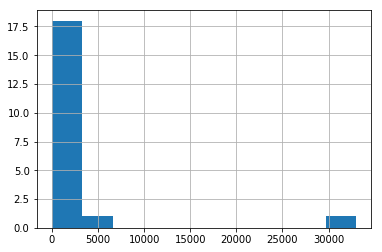

In [16]:
asignados_por_segmento.sample(n=20, replace=False).hist(bins=10)

### *Grafico de la distribucion de todos los segmentos*

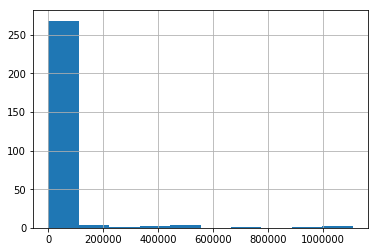

In [17]:
asignados_por_segmento.hist(bins=10)

### *Graficar cantidad de asignaciones por día*

In [18]:
asignaciones_por_dia = sample_ext_df.groupby('day').count()['count']

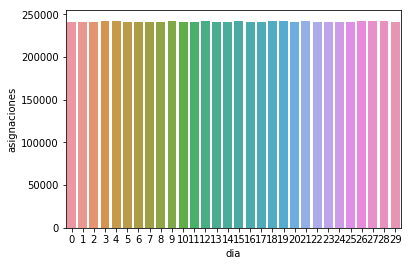

In [19]:
data = pd.DataFrame({'dia':asignaciones_por_dia.index.values, 'asignaciones':asignaciones_por_dia.values})
ax = sns.barplot(x='dia', y = 'asignaciones',data=data)

### *Cuál es la distribución por categoría de segmento. Es decir, cuántas asignaciones fueron hechas a segmentos de categoría 0, cuántos de categoría 1, y así sucesivamente.*

In [20]:
asignaciones_por_categoria = sample_ext_df.groupby('category').count()['count']

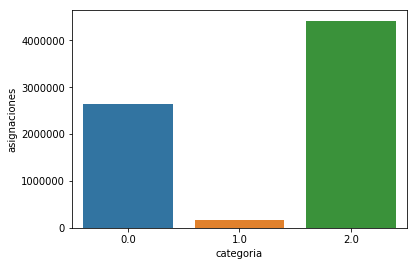

In [21]:
data = pd.DataFrame({'categoria':asignaciones_por_categoria.index.values, 'asignaciones':asignaciones_por_categoria.values})
ax = sns.barplot(x='categoria', y = 'asignaciones',data=data)

### *Estudiar correlación entre categoría de segmento y el día de asignación*

In [22]:
asignaciones_por_categoria_dia = sample_ext_df.groupby(by=['day','category']).count()['count']

En el siguiente grafico quiero ver como es la cantidad de asignaciones dependiendo del dia y la categoria en un mapa de calor. Se puede observar que dentro de cada categoria la cantidad de asinaciones por dia es bastante uniforme

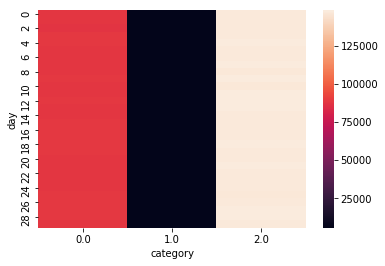

In [23]:
sns.heatmap(asignaciones_por_categoria_dia.reset_index().pivot("day","category","count"))

In [24]:
asignaciones_por_categoria_dia.reset_index().corr()

,day,category,count
day,1.000000,0.000000,0.000901
category,0.000000,1.000000,0.414017
count,0.000901,0.414017,1.000000


### *Correlacion entre variables categoricas sacado de * https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

In [25]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [26]:
data = asignaciones_por_categoria_dia.reset_index()

In [27]:
cramers_v(data['day'], data['category'])

0.0